# Analysis
## 1. SNN

In [17]:
from RandmanFunctions import get_randman_dataset
from Utilities import spike_to_label, voltage_to_logits

import wandb
import numpy as np
import pandas as pd
import snntorch as snn
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme()

device = 'cpu'

In [3]:
class SNN(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, learn_beta, beta=0.95):
        super(SNN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, learn_beta=learn_beta)

        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, learn_beta=learn_beta, reset_mechanism='none')

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                # nn.init.zeros_(m.bias)

    def forward(self, x):
        # import pdb; pdb.set_trace()
        batch_size, time_steps, num_neurons = x.shape
        x = x.permute(1, 0, 2)  # (time, batch, neurons)

        mem1, mem2 = [torch.zeros(batch_size, layer.out_features, device=x.device)
                      for layer in [self.fc1, self.fc2]]

        mem2_rec = []

        for t in range(time_steps):
            spk1, mem1 = self.lif1(self.fc1(x[t]), mem1)
            _, mem2 = self.lif2(self.fc2(spk1), mem2)
            mem2_rec.append(mem2)

        return torch.stack(mem2_rec, dim=0)  # (time_steps, batch_size, num_outputs)

In [3]:
class NoBiasSNN(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, learn_beta, beta=0.95):
        super(NoBiasSNN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden, bias=False)
        self.lif1 = snn.Leaky(beta=beta, learn_beta=learn_beta)

        self.fc2 = nn.Linear(num_hidden, num_outputs, bias=False)
        self.lif2 = snn.Leaky(beta=beta, learn_beta=learn_beta, reset_mechanism='none')

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                # nn.init.zeros_(m.bias)

    def forward(self, x):
        # import pdb; pdb.set_trace()
        batch_size, time_steps, num_neurons = x.shape
        x = x.permute(1, 0, 2)  # (time, batch, neurons)

        mem1, mem2 = [torch.zeros(batch_size, layer.out_features, device=x.device)
                      for layer in [self.fc1, self.fc2]]

        mem2_rec = []

        for t in range(time_steps):
            spk1, mem1 = self.lif1(self.fc1(x[t]), mem1)
            _, mem2 = self.lif2(self.fc2(spk1), mem2)
            mem2_rec.append(mem2)

        return torch.stack(mem2_rec, dim=0)  # (time_steps, batch_size, num_outputs)


### Output Layer Voltage

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import seaborn as sns
import numpy as np
sns.set_theme()

def plot_output_layer_voltages(snn, x, label):
    """plot voltage trace of the output layer of snn

    Args:
        snn (nn.Module): the model
        x (tensor): of shape [batch=1, time steps, nb_inputs]
    """
    mem_out = snn(x) # mem_out shape: [time steps, batch=1, classes]
    pred_label = spike_to_label(mem_out, scheme = 'highest_voltage')
    mem_out = mem_out.cpu().detach().numpy().squeeze(axis=1)
    
    df = pd.DataFrame(mem_out, columns = ['mem-0', 'mem-1'])
    
    # plotting
    sns.lineplot(df)
    plt.title(f'Class Label: {label.item()}, Model Pred:{pred_label.item()}')
    plt.xlabel('time step')
    plt.ylabel('voltage')
    plt.show()

def _test_plot_layer_voltages():
    snn = SNN(10, 20, 2, False)
    x = torch.rand([1, 100, 10]) # [batch, time steps, neurons]
    plot_output_layer_voltages(snn, x, 0)
    
# _test_plot_layer_voltages()
    

### Hidden Layer Spike Rasters

In [6]:
def spike_train_to_events(spike_train):
    # spike_train shape: [time_steps, neurons]
    # output shape: [events, 2]. ([time step, neuron] pairs)
    
    non_zeros_indicies = np.nonzero(spike_train) # nonzeros: ([...dim 1 indicies for nonzero....], [...dim 2 indicies...])
    return np.stack(non_zeros_indicies).T

def plot_hidden_layer_spike_raster(snn, x):
    spikes = []
    def hook(module, input, output):
        spikes.append(output[0][0].detach().numpy()) # first 0 index the output, the second index the batch dimension
    
    handle = snn.lif1.register_forward_hook(hook)
    snn(x)
    handle.remove()
    
    spikes = np.stack(spikes)
    events = spike_train_to_events(spikes)
    df = pd.DataFrame(events, columns=['time step', 'neuron'])
    
    # plotting
    sns.scatterplot(df, x = 'time step', y = 'neuron')
    plt.title('Hidden Layer Spike Rasters')
    plt.legend([],[], frameon=False) # no labels
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True)) # plot intergers only
    plt.xlabel('time step')
    plt.ylabel('neurons')
    plt.show()
    
def _test_plot_hidden_layer_spikes():
    # setup
    model = SNN(3,50,2, False)   
    x = torch.randn([1, 100, 3]) # [batch=1, time_steps, neurons]
    plot_hidden_layer_spike_raster(model, x)
    
# _test_plot_hidden_layer_spikes()

### Logits Difference distribution

In [7]:
def plot_logits_difference_distribution(model, dataset):
    val_loader = DataLoader(dataset, batch_size=256)
    logits = []
    for batch, (x, y) in enumerate(val_loader):
        mem_out = model(x)
        logits.append(voltage_to_logits(mem_out).detach().numpy())
        
    logits = np.concatenate(logits, axis = 0) # logits shape [nb_samples, 2]
    diff = np.expand_dims((logits[:, 0] - logits[:, 1]), axis = -1)
    df = pd.DataFrame(diff, columns=['diff'])
    
    sns.histplot(df)
    plt.xlabel('logit_0 - logit_1')
    plt.title('Logits Difference Distribution')
    plt.show()
    

### Plot

In [11]:
def get_run_and_model(run_id, model_idx):
    ENTITY = 'DarwinNeuron'
    PROJECT = 'ES-Randman'

    # obtain run for hyperparameter records
    api = wandb.Api()
    run = api.run(f'{ENTITY}/{PROJECT}/{run_id}')
    
    # download 
    artifact = run.logged_artifacts()[model_idx]
    model_path = artifact.download() 
    
    # load model
    model = NoBiasSNN(run.config['nb_input'], run.config['nb_hidden'], run.config['nb_output'], run.config['learn_beta'])
    model.load_state_dict(torch.load(f'{model_path}/best-model.pth', weights_only = True))
    
    return run, model

# run_id = 'wvoaejgq' # cross-entropy-no-weight, the GOOD one
# run_id = 'xlqvzaqr' # diff-sigmoid-reg
# run_id = '7ktqsno0' # cross-entropy
run, model = get_run_and_model('wvoaejgq', model_idx=598)

wandb:   1 of 1 files downloaded.  


(diff-sigmoid-reg, model-4, sample-14) Why membrane decay at diff rate? Why at different initail value? 


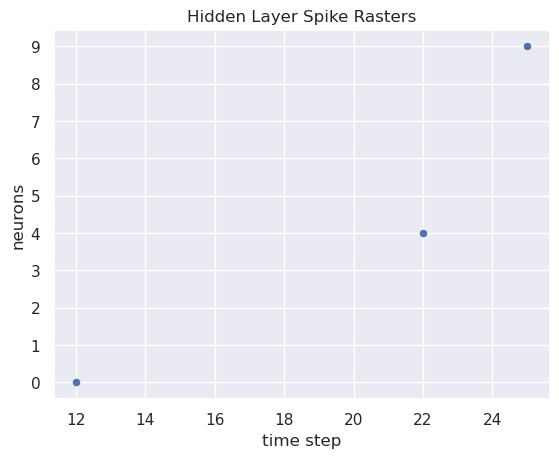

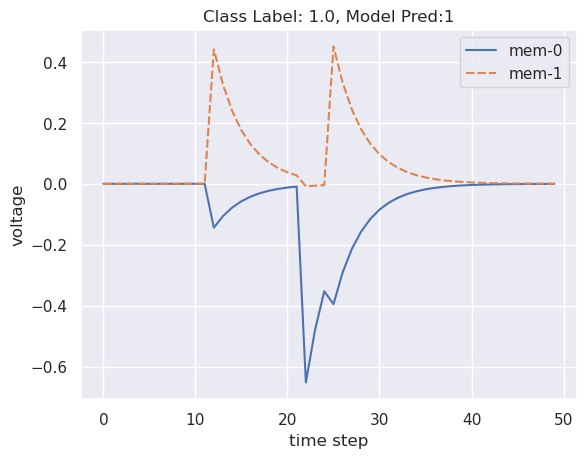

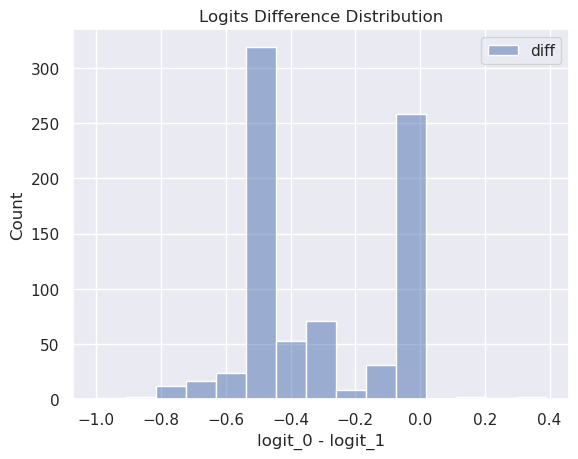

In [ ]:
from sklearn.model_selection import train_test_split
def plot_main(run, model):
    # prepare dataset
    train_dataset, val_dataset = train_test_split(get_randman_dataset(run.config['nb_output'], run.config['nb_input'], run.config['nb_steps'], run.config['nb_data_samples']), test_size=0.2, shuffle=False)

    sample_idx = 14
    x = val_dataset[sample_idx][0].unsqueeze(axis=0) # unsqueeze to insert batch dimension
    y = val_dataset[sample_idx][1].unsqueeze(axis=0)
    
    plot_hidden_layer_spike_raster(model, x)
    plot_output_layer_voltages(model, x, y)
    plot_logits_difference_distribution(model, val_dataset)
    
plot_main(run, model)

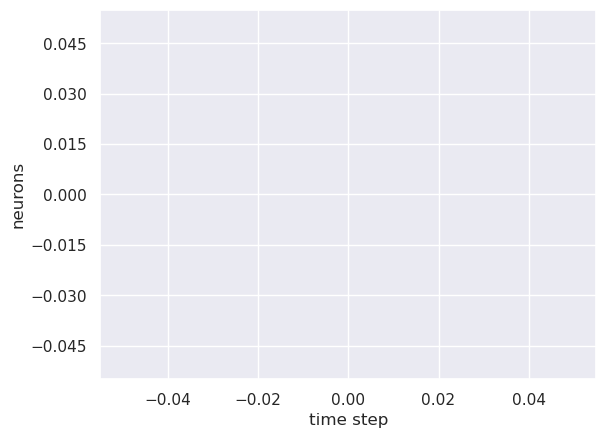

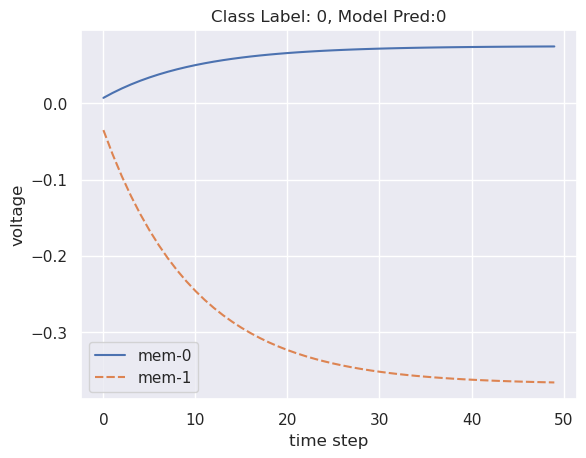

In [54]:
def plot_idle_model(model):
    x = torch.zeros([1, 50, 100])
    plot_hidden_layer_spike_raster(model, x)
    plot_output_layer_voltages(model, x, label=torch.tensor([0,]))
plot_idle_model(model)

### Parameter Distribution

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


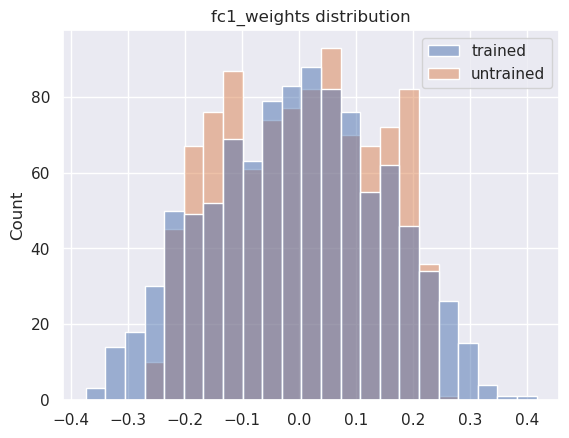

In [10]:
def plot_param_distribution(model):    
    _, trained_model = get_run_and_model('wvoaejgq', 50)
    _, untrained_model = get_run_and_model('wvoaejgq', 1)
    
    fc1_weights = []
    for model in (trained_model, untrained_model):
        param_dict = dict(model.named_parameters())
        fc1_weights.append(param_dict['fc1.weight'].detach().numpy().reshape([-1,]))
    fc1_weights = np.stack(fc1_weights, axis = 0).T
    
    df = pd.DataFrame(fc1_weights, columns=['trained', 'untrained'])
    sns.histplot(df)
    plt.title('fc1_weights distribution')
    
plot_param_distribution(model)

### Confusion Matrix

In [ ]:
def plot_confusion_matrix(model, loader, device):
    model.eval()
    model.to(device)

    # Loop for classifying
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            # import pdb; pdb.set_trace()
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # shape: [batch_size, num_classes, time_steps]
            outputs = outputs.permute(1, 2, 0)
            outputs = torch.max(outputs, dim = -1)[0]

            predicted = torch.argmax(outputs, dim=1)  # predicted class
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

        # Concatenate all batches
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        # Convert to numpy
        y_true = all_labels.numpy()
        y_pred = all_preds.numpy()

        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", conf_matrix)

        # Full classification report (Precision, Recall, F1-score for each class)
        print("\nClassification Report:\n", classification_report(y_true, y_pred))

        # Overall accuracy
        print("\nAccuracy: ", accuracy_score(y_true, y_pred))

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

In [14]:
def actual_plot_confusion(model):
    train_dataset, val_dataset = train_test_split(get_randman_dataset(run.config['nb_output'], run.config['nb_input'], run.config['nb_steps'], run.config['nb_data_samples']), test_size=0.2, shuffle=False)
    val_loader = DataLoader(val_dataset, 256)
    plot_confusion_matrix(model, val_loader, device)

Confusion Matrix:
 [[424   0]
 [  6 370]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       424
         1.0       1.00      0.98      0.99       376

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800


Accuracy:  0.9925


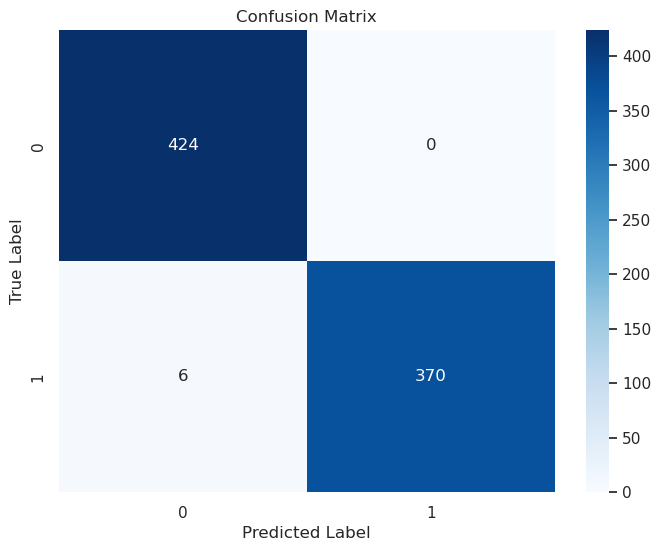

In [ ]:
actual_plot_confusion(model)

## 2. Competition Model

### Model Definition


In [2]:
class ExcitationPopulation(nn.Module):
    def __init__(self, nb_neurons, nb_input, nb_inh, beta, nb_decision_steps):
        super().__init__()        
        self.input_fc = nn.Linear(nb_input, nb_neurons, bias = False)
        self.recurrent_fc = nn.Linear(nb_neurons, nb_neurons, bias = False)
        self.inhibition_fc = nn.Linear(nb_inh, nb_neurons, bias = False)
        self.lif = snn.Leaky(beta, learn_beta = False, threshold=1, reset_mechanism='subtract')
        self.readout_fc = nn.Linear(nb_neurons, 1, bias=False)
        self.readout_lif = snn.Leaky(beta=0.95, reset_mechanism = 'none')
        self.nb_decision_steps = nb_decision_steps
        self.init_states(nb_decision_steps)       

    def get_nb_neurons(self):
        return self.input_fc.out_features
    
    def init_states(self, nb_decision_steps=None):
        # excitatory neurons
        self.mem = self.lif.init_leaky().to(device)
        self.last_spks_queue = [torch.zeros(self.get_nb_neurons(), device=device) for _ in range(nb_decision_steps if nb_decision_steps != None else len(self.last_spks_queue))]  
        
        # readout neuron
        self.readout_mem = self.readout_lif.init_leaky().to(device)
        self.readout_mem_rec = []

    def forward(self, input, inhibition):
        # excitatory neurons
        curr = torch.abs(self.input_fc(input)) + torch.abs(self.recurrent_fc(self.last_spks_queue[-1])) - torch.abs(self.inhibition_fc(inhibition))
        spk, self.mem = self.lif(curr, self.mem)
        
        # readout neuron
        readout_curr = torch.abs(self.readout_fc(spk))
        _, self.readout_mem = self.readout_lif(readout_curr, self.readout_mem)    
        
        # update spk record
        self.last_spks_queue.pop(0)
        self.last_spks_queue.append(spk.clone().detach())
        
        # update readout record
        self.readout_mem_rec.append(self.readout_mem.squeeze(dim=-1).clone())
        
        return spk
        
    def get_last_spikes_means(self):
        # stacked shape: [nb_decision_steps, batch_size, nb_neurons]
        # For each batch, the mean should include all the final steps and all the neurons (first and last dimension)
        # return shape: [batch_size,]
        return torch.stack(self.last_spks_queue).mean(dim = [0, 2])
    
    def get_readout(self):    
        # stacked shape [nb_decision_steps, batch_size]
        return torch.stack(self.readout_mem_rec[-self.nb_decision_steps: ]).mean(dim=0)
    
# def test_ep():
#     ep = ExcitationPopulation(nb_neurons=3, nb_input=10, nb_inh=1, beta=0.95, nb_decision_steps=5).to(device)
#     for _ in range(100):
#         fake_spk = torch.rand([64, 10], device=device)
#         fake_inh = torch.rand([64, 1], device=device)
#         out = ep(fake_spk, fake_inh)
#     print(ep.get_readout().shape)
        
# test_ep()

In [3]:
class CompetitionModel(nn.Module):
    def __init__(self, nb_input, nb_ext, nb_inh, beta_ext, beta_inh, nb_decision_steps):
        super().__init__()
        
        # excitatory
        self.excitatory_1 = ExcitationPopulation(nb_ext, nb_input, nb_inh, beta_ext, nb_decision_steps)
        self.excitatory_2 = ExcitationPopulation(nb_ext, nb_input, nb_inh, beta_ext, nb_decision_steps)
        
        # inhibitory.
        self.inh_fc = nn.Linear(nb_ext, 1, bias = False) # Note: two ext share same inh weights
        self.inh_lif = snn.Leaky(beta_inh, learn_beta = False)
        
        # records
        self.nb_decision_steps = nb_decision_steps
        
    def get_nb_ext(self):
        return self.excitatory_1.get_nb_neurons()
    
    def get_nb_inh(self):
        return self.inh_fc.out_features
    
    def init_states(self):
        self.excitatory_1.init_states()
        self.excitatory_2.init_states()
        self.mem_inh = self.inh_lif.init_leaky()
        
    def forward(self, x):        
        # change x shape from [batch, time steps, nb_input] to [time steps, batch, nb_input]
        x = x.permute([1, 0, 2])
        
        # pad time steps for model to go to steady states
        x = torch.cat([x, torch.zeros(5 + self.nb_decision_steps, x.shape[1], x.shape[2], device=device)])
        
        # initalize membrane potentials
        self.init_states()
        
        # init spikes with shape [nb_neurons]. The batch size will be broadcasted
        inh_spk = torch.zeros([self.get_nb_inh()], device=device)
        
        for t in range(len(x)):          
            # excitation
            ext_1_spk = self.excitatory_1(x[t], inh_spk)
            ext_2_spk = self.excitatory_2(x[t], inh_spk)
            
            # inhibition. Inhibitory neurons are excited, so curr should be positive
            curr_inh = torch.abs(self.inh_fc(ext_1_spk)) + torch.abs(self.inh_fc(ext_2_spk))
            
            inh_spk, self.mem_inh = self.inh_lif(curr_inh, self.mem_inh)
        
        # return shape: [batch_size, 2], where column 0 is ext1, column 1 is ext2
        return torch.stack([self.excitatory_1.get_readout(), self.excitatory_2.get_readout()], dim = 1)
    
    def get_mem_rec(self):
        # stacked shape: [batch, time_steps]
        mem_rec_1 = torch.stack(self.excitatory_1.readout_mem_rec, dim = 1)
        mem_rec_2 = torch.stack(self.excitatory_2.readout_mem_rec, dim = 1)
        
        # return shape: [batch, time_steps, 2]
        return torch.stack([mem_rec_1, mem_rec_2], dim=2)

# def test_cm():
#     cm = CompetitionModel(nb_input=10, nb_ext=3, nb_inh=1, beta_ext=0.75, beta_inh=0.95, nb_decision_steps=10)
#     x = torch.rand([64, 100, 10])
#     print(cm(x).shape)
# test_cm()
            

In [70]:
def prepare_untrained():
    nb_input = 100    
    model  = CompetitionModel(nb_input, nb_ext=3, nb_inh=1, beta_ext=0.95, beta_inh=0.75, nb_decision_steps=10)
    
    return model
model = prepare_untrained()

In [74]:
def get_run_and_competition_model(run_id, model_idx):
    ENTITY = 'DarwinNeuron'
    PROJECT = 'ES-Randman-Competition'

    # obtain run for hyperparameter records
    api = wandb.Api()
    run = api.run(f'{ENTITY}/{PROJECT}/{run_id}')
    
    # download 
    artifact = run.logged_artifacts()[model_idx]
    model_path = artifact.download() 
    
    # # load model
    model = CompetitionModel(run.config['nb_input'], run.config['nb_ext'], run.config['nb_inh'], run.config['beta_ext'], run.config['beta_inh'], run.config['nb_decision_steps'])
    mean = torch.load(f'{model_path}/checkpoint_epoch_{model_idx}.pth', weights_only=True)
    offset = 0
    for p in model.parameters():
        numel = p.numel()
        p.data.copy_(mean[offset:offset+numel].view_as(p))
        offset += numel
    
    return run, model

run, model = get_run_and_competition_model('4ldzwsm1', model_idx=6)

wandb:   1 of 1 files downloaded.  


In [75]:
def get_x(run, model):
    model.init_states()
    dataset = get_randman_dataset(run.config['nb_output'], run.config['nb_input'], run.config['nb_steps'], run.config['nb_data_samples'])
    i = 1
    x = dataset[i:i+1][0]
    print(f'pred:{dataset[i:i+1][1]}, label:{model(x).argmax(1)}')
    return x
x = get_x(run, model)

pred:tensor([0.]), label:tensor([0])


### Confusion Matrix

Confusion Matrix:
 [[177  31]
 [  4 188]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.85      0.91       208
         1.0       0.86      0.98      0.91       192

    accuracy                           0.91       400
   macro avg       0.92      0.92      0.91       400
weighted avg       0.92      0.91      0.91       400


Accuracy:  0.9125


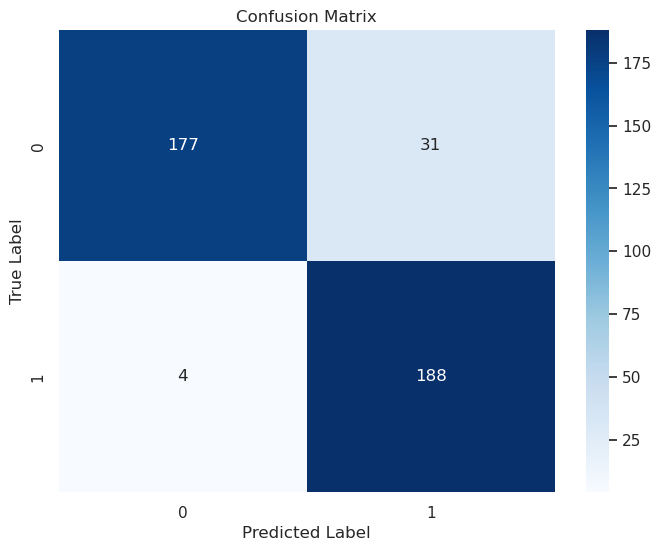

In [79]:
def plot_confusion_matrix_competition(model, loader, device):
    model.eval()
    model.to(device)

    # Loop for classifying
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            # import pdb; pdb.set_trace()
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # shape: [batch_size, num_classes, time_steps]

            predicted = torch.argmax(outputs, dim=1)  # predicted class
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())

        # Concatenate all batches
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        # Convert to numpy
        y_true = all_labels.numpy()
        y_pred = all_preds.numpy()

        # Confusion matrix
        conf_matrix = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix:\n", conf_matrix)

        # Full classification report (Precision, Recall, F1-score for each class)
        print("\nClassification Report:\n", classification_report(y_true, y_pred))

        # Overall accuracy
        print("\nAccuracy: ", accuracy_score(y_true, y_pred))

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

def actual_plot_confusion_competition(model):
    train_dataset, val_dataset = train_test_split(get_randman_dataset(run.config['nb_output'], run.config['nb_input'], run.config['nb_steps'], run.config['nb_data_samples']), test_size=0.2, shuffle=False)
    val_loader = DataLoader(val_dataset, 256)
    plot_confusion_matrix_competition(model, val_loader, device)
actual_plot_confusion_competition(model)

### Voltages of Readout Neurons

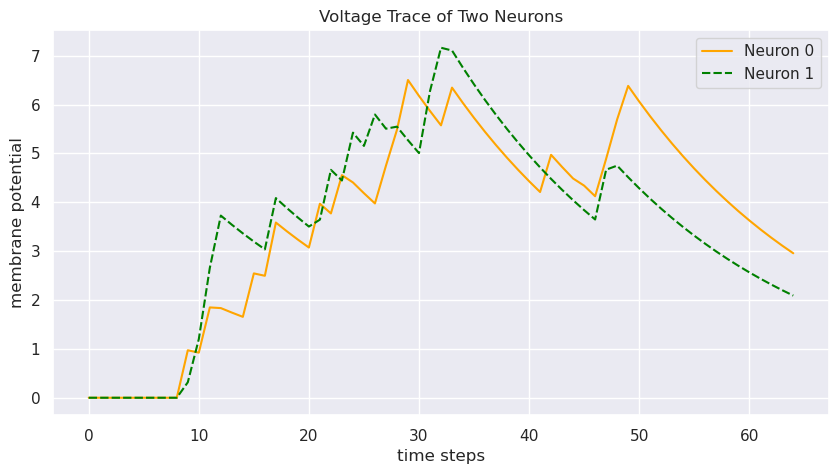

In [76]:
def plot_spike_train_raster(spike_train):
    # Find spike events
    times, neurons = torch.nonzero(spike_train, as_tuple=True)

    df = pd.DataFrame({
        'Time': times.numpy(),
        'Neuron': neurons.numpy()
    })

    # Scatter plot
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=df, x='Time', y='Neuron', s=20)  # s is marker size
    plt.title('Spike Raster Plot')
    plt.xlabel('Time Step')
    plt.ylabel('Neuron Index')
    plt.show()

def plot_readout_mem(model, x):
    model.init_states()
    out = model(x)   
    
    # plot voltage trace
    mem_rec = model.get_mem_rec().squeeze(dim=0).detach()
    
    df = pd.DataFrame(mem_rec.numpy(), columns=['Neuron 0', 'Neuron 1'])

    # Now plot with seaborn
    plt.figure(figsize=(10, 5))
    sns.lineplot(df, palette=['orange', 'green'])
    plt.title('Voltage Trace of Two Neurons')
    plt.xlabel('time steps')
    plt.ylabel('membrane potential')
    plt.show()

    
plot_readout_mem(model, x)

### Raster Plot of Excitation Neurons

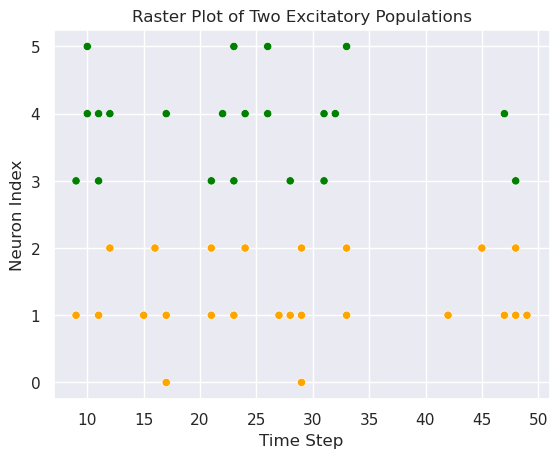

In [77]:
def plot_ext_raster(model ,x):    
    model.init_states()
    
    # records
    ext_1_spk_rec = []
    ext_2_spk_rec = []
    
    handle_1 = model.excitatory_1.lif.register_forward_hook(lambda _, __, out: ext_1_spk_rec.append(out[0].squeeze(dim=0).clone()))
    handle_2 = model.excitatory_2.lif.register_forward_hook(lambda _, __, out: ext_2_spk_rec.append(out[0].squeeze(dim=0).clone()))
    
    model(x)    

    handle_1.remove()
    handle_2.remove()
    
    # ext_i_spk_rec shape: [time_steps, ext_neurons] (stacked)
    ext_1_spk_rec = torch.stack(ext_1_spk_rec)
    ext_2_spk_rec = torch.stack(ext_2_spk_rec)
    
    # new shape: [nb_spikes, neuron]
    ext_1_spk_rec = torch.nonzero(ext_1_spk_rec)
    ext_2_spk_rec = torch.nonzero(ext_2_spk_rec)
    ext_2_spk_rec[:,1] += 3 
    
    combined_record = torch.cat([ext_1_spk_rec, ext_2_spk_rec], dim=0)
    
    df = pd.DataFrame(combined_record.detach(), columns=['time', 'neuron'])
    
    colors = np.where(df['neuron'].to_numpy() <= 2, 'orange', 'green')
    
    sns.scatterplot(df, x='time', y='neuron', c = colors)

    plt.title('Raster Plot of Two Excitatory Populations')
    plt.xlabel('Time Step')
    plt.ylabel('Neuron Index')
    # plt.legend(title="Population")
    plt.show()

plot_ext_raster(model, x)

### Voltages of Excitation Neurons

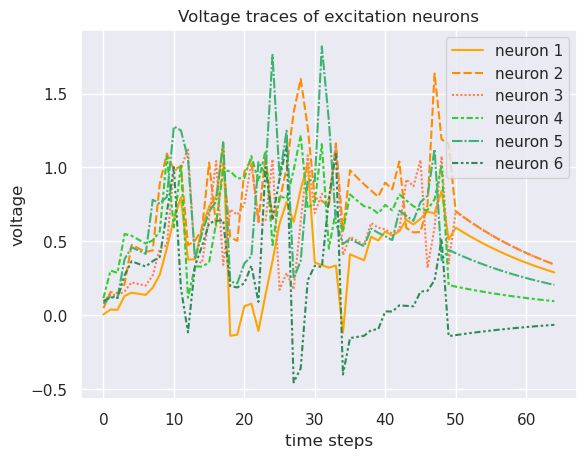

In [78]:
def plot_ext_voltages(model, x):  
    model.init_states()  
    # records
    ext_1_mem_rec = []
    ext_2_mem_rec = []
    
    handle_1 = model.excitatory_1.lif.register_forward_hook(lambda _, __, out: ext_1_mem_rec.append(out[1].squeeze(dim=0).clone()))
    handle_2 = model.excitatory_2.lif.register_forward_hook(lambda _, __, out: ext_2_mem_rec.append(out[1].squeeze(dim=0).clone()))
    
    model(x)    

    handle_1.remove()
    handle_2.remove()
    
    # stacked shape: [time steps, neurons]
    ext_1_mem_rec = torch.stack(ext_1_mem_rec).detach()
    ext_2_mem_rec = torch.stack(ext_2_mem_rec).detach()
    
    combined_record = torch.cat([ext_1_mem_rec, ext_2_mem_rec], dim=1)
    df = pd.DataFrame(combined_record, columns = [f'neuron {i}' for i in range(1, 7)])
    colors = ['orange', 'darkorange', 'coral',   # three orange-ish colors
          'limegreen', 'mediumseagreen', 'seagreen']  # three green-ish colors
    sns.lineplot(df, palette=colors)
    plt.title('Voltage traces of excitation neurons')
    plt.xlabel('time steps')
    plt.ylabel('voltage')
    plt.legend()
    plt.show()

plot_ext_voltages(model, x)